In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.nasnet import NASNetMobile,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = NASNetMobile(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(10136, 1056)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(10136, 1056)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True, random_state=1)

In [ ]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 11.0min


[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137795, total= 6.6min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.138477, total= 6.6min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137255, total= 6.6min
[CV] gamma=1e-06, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.137795, total= 6.6min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137695, total= 6.6min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.136986, total= 6.7min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.136986, total= 6.7min
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 11.1min


[CV] .............. gamma=1e-08, C=0.01, score=0.139442, total= 6.7min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.138889, total= 6.7min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.139165, total= 6.7min
[CV] gamma=1e-05, C=0.01 .............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.137795, total= 6.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.137695, total= 6.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.138751, total= 6.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.138889, total= 6.7min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.2min


[CV] .............. gamma=1e-06, C=0.01, score=0.137795, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138889, total= 6.5min
[CV] gamma=0.0001, C=0.01 ............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138477, total= 6.6min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.138751, total= 6.6min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.136986, total= 6.6min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.137795, total= 6.5min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.139442, total= 6.6min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 22.1min


[CV] .............. gamma=1e-05, C=0.01, score=0.139442, total= 6.8min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.139165, total= 6.8min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.138889, total= 6.8min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.136986, total= 6.8min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.137255, total= 6.9min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.137695, total= 6.9min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.138477, total= 6.9min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 32.4min


[CV] ............... gamma=0.01, C=0.01, score=0.435039, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.441176, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.439961, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.441147, total= 6.2min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.442022, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.436508, total= 6.1min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] ............... gamma=0.01, C=0.01, score=0.442346, total= 6.1min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 33.0min


[CV] .............. gamma=0.001, C=0.01, score=0.138889, total= 6.8min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=0.001, C=0.01, score=0.137795, total= 6.8min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.139442, total= 6.8min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.138477, total= 6.8min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.139165, total= 6.8min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.387695, total= 7.2min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] ................ gamma=0.1, C=0.01, score=0.384540, total= 7.2min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed: 43.8min


[CV] ................ gamma=1.0, C=0.01, score=0.193137, total= 8.7min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.221680, total= 8.8min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.214286, total= 8.7min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.221457, total= 8.8min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.223984, total= 8.7min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.217520, total= 8.8min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.221563, total= 8.7min
[CV] gamma=1e-07, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 54.5min


[CV] ............... gamma=1e-08, C=0.1, score=0.137255, total= 6.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.137795, total= 6.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.137795, total= 6.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138477, total= 6.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.139165, total= 6.4min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138889, total= 6.4min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.138751, total= 6.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 57.3min


[CV] ............... gamma=1e-07, C=0.1, score=0.137795, total= 6.4min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=10.0, C=0.01, score=0.205179, total= 9.3min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.138751, total= 6.5min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.138889, total= 6.4min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.139165, total= 6.5min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.139442, total= 6.5min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=1e-06, C=0.1, score=0.136986, total= 6.5min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 67.6min


[CV] ............... gamma=1e-05, C=0.1, score=0.137795, total= 6.7min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.137795, total= 6.7min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138477, total= 6.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.139165, total= 6.6min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138889, total= 6.7min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ............... gamma=1e-05, C=0.1, score=0.138751, total= 6.7min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .............. gamma=0.0001, C=0.1, score=0.137695, total= 6.7min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 75.2min


[CV] .............. gamma=0.0001, C=0.1, score=0.137795, total= 6.8min
[CV] gamma=0.1, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.138477, total= 6.8min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.570450, total= 5.3min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.550781, total= 5.3min
[CV] gamma=0.1, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.138889, total= 6.7min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=0.001, C=0.1, score=0.567913, total= 5.4min
[CV] gamma=1.0, C=0.1 ................................................
[CV] .............. gamma=0.0001, C=0.1, score=0.138751, total= 6.8min
[CV] gamma=1.0, C=0.1 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 83.1min


[CV] ................. gamma=0.1, C=0.1, score=0.645669, total= 5.8min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.645669, total= 5.8min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.653808, total= 5.8min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] ................. gamma=0.1, C=0.1, score=0.662028, total= 5.7min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.661706, total= 5.8min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.654113, total= 5.8min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.670319, total= 5.8min
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 103.5min


[CV] ............... gamma=1e-07, C=1.0, score=0.138889, total= 6.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.139165, total= 6.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-07, C=1.0, score=0.139442, total= 6.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.137695, total= 6.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.137255, total= 6.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.136986, total= 6.6min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-06, C=1.0, score=0.137795, total= 6.7min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 112.7min


[CV] ............... gamma=1e-05, C=1.0, score=0.139165, total= 6.7min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=1e-05, C=1.0, score=0.139442, total= 6.7min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.812500, total= 2.3min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.835616, total= 2.3min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.883789, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.909980, total= 1.4min
[CV] gamma=0.01, C=1.0 ...............................................
[CV] ............... gamma=0.001, C=1.0, score=0.800000, total= 2.3min
[CV] gamma=0.1, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 116.7min


[CV] .............. gamma=0.0001, C=1.0, score=0.561753, total= 5.2min
[CV] gamma=1.0, C=1.0 ................................................
[CV] .............. gamma=0.0001, C=1.0, score=0.565476, total= 5.2min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.900794, total= 1.4min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.914513, total= 1.4min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................ gamma=0.01, C=1.0, score=0.889442, total= 1.4min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.847656, total= 5.3min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] ................. gamma=0.1, C=1.0, score=0.846380, total= 5.3min
[CV] gamma=10.0, C=1.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 128.5min


[CV] ................ gamma=10.0, C=1.0, score=0.341797, total= 8.8min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.356164, total= 8.8min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.343137, total= 8.7min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.343504, total= 8.7min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.136986, total= 6.3min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.137695, total= 6.4min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.137255, total= 6.3min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed: 141.9min


[CV] .............. gamma=1e-07, C=10.0, score=0.138889, total= 6.6min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.139165, total= 6.5min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.139442, total= 6.5min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.137695, total= 6.7min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.136986, total= 6.7min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.137255, total= 6.7min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.812500, total= 2.3min
[CV] gamma=0.0001, C=10.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed: 150.2min


[CV] .............. gamma=0.001, C=10.0, score=0.885294, total= 1.2min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.808071, total= 2.2min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.883858, total= 1.2min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.812008, total= 2.3min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] ............. gamma=0.0001, C=10.0, score=0.828882, total= 2.2min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.902559, total= 1.2min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .............. gamma=0.001, C=10.0, score=0.902077, total= 1.2min
[CV] gamma=0.1, C=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed: 158.4min


[CV] ................ gamma=0.1, C=10.0, score=0.844488, total= 5.5min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.854331, total= 5.5min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.848665, total= 5.4min
[CV] gamma=10.0, C=10.0 ..............................................
[CV] ................ gamma=0.1, C=10.0, score=0.866204, total= 5.5min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.846230, total= 5.5min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.863817, total= 5.4min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] ................ gamma=0.1, C=10.0, score=0.857570, total= 5.5min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 171.3min


[CV] ............... gamma=10.0, C=10.0, score=0.380716, total= 8.8min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............... gamma=10.0, C=10.0, score=0.353586, total= 9.1min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.137795, total= 6.6min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138477, total= 6.5min
[CV] gamma=1e-06, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138751, total= 6.5min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.138889, total= 6.5min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............. gamma=1e-08, C=100.0, score=0.139165, total= 6.5min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 433 tasks      | elapsed: 180.5min


[CV] ............. gamma=1e-05, C=100.0, score=0.823588, total= 2.2min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-07, C=100.0, score=0.139165, total= 6.6min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-07, C=100.0, score=0.139442, total= 6.6min
[CV] gamma=0.001, C=100.0 ............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.568452, total= 5.1min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.821429, total= 2.2min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.824056, total= 2.2min
[CV] gamma=0.01, C=100.0 .............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.882353, total= 1.2min
[CV] gamma=0.01, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed: 185.0min


[CV] .............. gamma=0.01, C=100.0, score=0.912402, total= 1.3min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.920870, total= 1.3min
[CV] gamma=1.0, C=100.0 ..............................................
[CV] .............. gamma=0.01, C=100.0, score=0.923687, total= 1.3min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.923611, total= 1.3min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.928429, total= 1.3min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .............. gamma=0.01, C=100.0, score=0.920319, total= 1.3min
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............... gamma=0.1, C=100.0, score=0.855882, total= 5.3min
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 497 tasks      | elapsed: 202.1min


[CV] ............ gamma=1e-08, C=1000.0, score=0.136986, total= 6.7min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.349159, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.339567, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.366071, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.380716, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.348860, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .............. gamma=10.0, C=100.0, score=0.353586, total= 9.0min
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 209.4min


[CV] ............ gamma=1e-05, C=1000.0, score=0.880906, total= 1.2min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.899110, total= 1.1min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.899901, total= 1.2min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.889881, total= 1.2min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ........... gamma=0.0001, C=1000.0, score=0.918945, total=  58.8s
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.887450, total= 1.2min
[CV] gamma=0.001, C=1000.0 ...........................................
[CV] ............ gamma=1e-05, C=1000.0, score=0.904573, total= 1.2min
[CV] gamma=0.01, C=1000.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 228.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [ ]:
top_model.cv_results_

{'mean_fit_time': array([371.47821882, 370.72306318, 366.84829237, 369.8954741 ,
        381.95874565, 378.13151786, 340.00105906, 409.04320397,
        496.45731809, 525.42069402, 358.92914469, 358.05185182,
        362.21831598, 371.78124931, 376.1540221 , 293.68266389,
        143.78796163, 327.15376618, 483.5440908 , 514.31782146,
        359.4319726 , 358.05542417, 369.04273677, 374.1125571 ,
        284.07009182, 120.29360571,  70.69206319, 304.32216942,
        472.88523238, 497.62456734, 354.39213126, 363.53971634,
        370.076508  , 281.96132023, 116.87136567,  59.83057997,
         64.54513385, 312.95205014, 485.98744211, 508.12975156,
        361.09468894, 369.05041044, 279.93881474, 116.8696049 ,
         60.22900629,  51.23132598,  64.88190684, 310.81833131,
        490.52475288, 513.0383189 , 370.51635978, 281.91133986,
        116.25951188,  59.35923643,  50.04587514,  51.79537547,
         64.31272321, 308.26321056, 471.50649359, 434.5564487 ]),
 'mean_score_time': a

In [ ]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.43893, std: 0.00307, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.38348, std: 0.00706, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.21764, std: 0.00858, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.20067, std: 0.00625, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.13822, std: 0.00079, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [ ]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.01, 'C': 10.0} - score: 0.9245


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


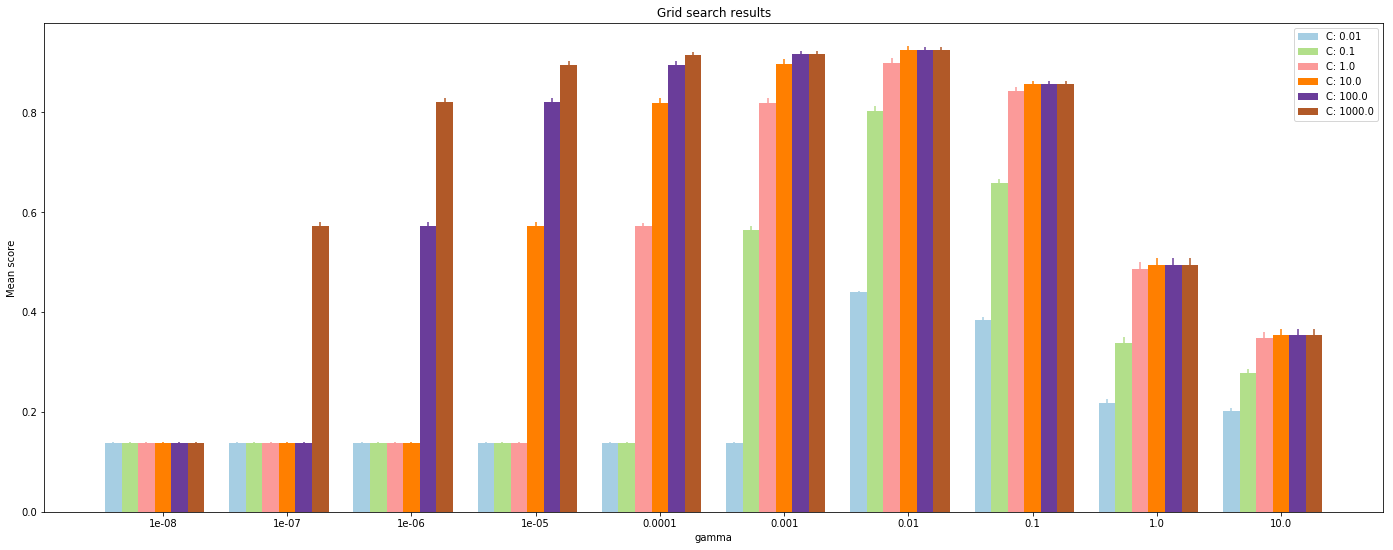

In [ ]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()